In [111]:
# import needed libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
from datetime import datetime
from scipy import stats
import os

import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler

In [131]:
df = pd.read_csv('./stock.csv')
print(len(df))

10810


<AxesSubplot:>

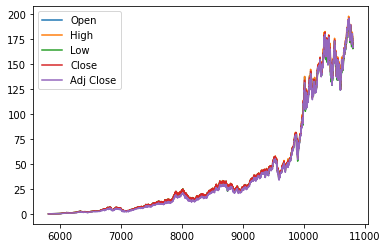

In [132]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

#Variables for training
cols = list(df)[1:6]
df_for_training = df[cols].astype(float)

# for plotting
df_for_plot = df_for_training.tail(5000)
df_for_plot.plot.line()

Open         1.000000
High         0.999945
Low          0.999933
Close        0.999861
Adj Close    0.999620
dtype: float64


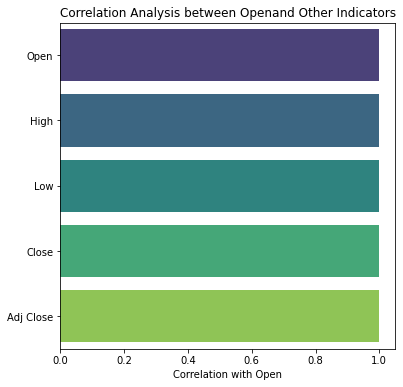

In [133]:
# Calculating correlations
correlations = df[cols].corrwith(df['Open'])

print(correlations)
# Creating a bar plot for correlation analysis
plt.figure(figsize=(6, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')
plt.xlabel('Correlation with Open')
plt.title('Correlation Analysis between Openand Other Indicators')
plt.show()

In [134]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

trainX = []
trainY = []


n_future = 1
n_past = 20

for i in range(n_past, len(df_for_training_scaled) - n_future + 1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1: i + n_future, 0])
trainX, trainY = np.array(trainX), np.array(trainY)


In [135]:

print(trainX.shape)
print(trainY.shape)

(10790, 20, 5)
(10790, 1)


In [89]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss = 'mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20, 64)            17920     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [90]:
history=model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
607/607 [==============================] - 6s 8ms/step - loss: 0.0098 - val_loss: 0.2071
Epoch 2/10
607/607 [==============================] - 4s 7ms/step - loss: 0.0040 - val_loss: 0.8783
Epoch 3/10
607/607 [==============================] - 4s 7ms/step - loss: 0.0030 - val_loss: 0.9676
Epoch 4/10
607/607 [==============================] - 4s 7ms/step - loss: 0.0028 - val_loss: 0.4421
Epoch 5/10
607/607 [==============================] - 4s 7ms/step - loss: 0.0025 - val_loss: 0.1735
Epoch 6/10
607/607 [==============================] - 5s 8ms/step - loss: 0.0028 - val_loss: 0.0225
Epoch 7/10
607/607 [==============================] - 4s 7ms/step - loss: 0.0025 - val_loss: 0.1580
Epoch 8/10
607/607 [==============================] - 4s 7ms/step - loss: 0.0025 - val_loss: 0.3939
Epoch 9/10
607/607 [==============================] - 4s 7ms/step - loss: 0.0023 - val_loss: 0.3491
Epoch 10/10
607/607 [==============================] - 5s 8ms/step - loss: 0.0028 - val_loss: 0.1103

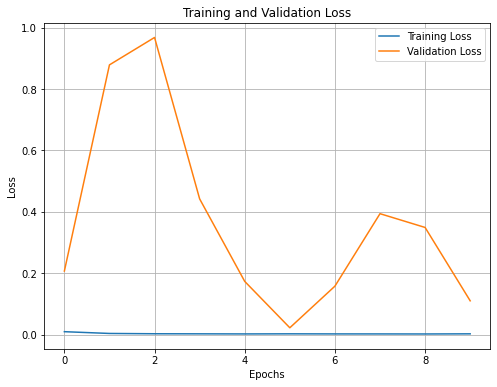

In [92]:
# Extracting loss and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the loss graph
plt.figure(figsize=(8, 6))  # Set the figure size

# Plotting the training and validation loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

3/3 [==============================] - 0s 3ms/step


<AxesSubplot:xlabel='Date', ylabel='Open'>

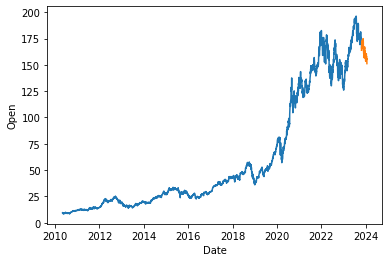

In [108]:
# Assuming you've defined and executed the previous code
num_future = 90

forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=num_future, freq='1d').tolist()
forecast = model.predict(trainX[-num_future:])
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)

# Reshaping the data
y_pred_future = y_pred_future[:, 0]  # Considering only the first column assuming it's the desired output

forecast_dates = [time.date() for time in forecast_period_dates]

df_forecast = pd.DataFrame({'Date': np.array(forecast_dates), 'Open': y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

original = df[['Date', 'Open']]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2010-5-1']


sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])


In [ ]:
train_dates = pd.to_datetime(df['Date'])

# Starting date from 2018
df = df[df['Date'] >= '2018-01-01']

# Variables for training
cols = ['Open']  # Considering only the 'Open' column for prediction
df_for_training = df[cols].astype(float)

scaler = StandardScaler()
scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

n_future = 1
n_past = 20

train_size = int(len(df_for_training_scaled) * 0.8)  # 80% of the data for training
train_data = df_for_training_scaled[0:train_size]
test_data = df_for_training_scaled[train_size - n_past:]

trainX, trainY = [], []
for i in range(n_past, len(train_data) - n_future + 1):
    trainX.append(train_data[i - n_past:i, 0])
    trainY.append(train_data[i + n_future - 1, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(n_past, 1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

# Splitting data into training and validation sets
val_split = 0.1  # 10% of the data for validation
val_size = int(len(trainX) * val_split)
val_X = trainX[-val_size:]
val_Y = trainY[-val_size:]
trainX = trainX[:-val_size]
trainY = trainY[:-val_size]

history = model.fit(trainX, trainY, epochs=10, batch_size=8, verbose=1, validation_data=(val_X, val_Y))

# Extracting loss and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the loss graph
plt.figure(figsize=(8, 6))  # Set the figure size

# Plotting the training and validation loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predicting the test data
testX, testY = [], []
for i in range(n_past, len(test_data) - n_future + 1):
    testX.append(test_data[i - n_past:i, 0])
    testY.append(test_data[i + n_future - 1, 0])

testX, testY = np.array(testX), np.array(testY)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

y_pred_test = model.predict(testX)

# Inverse transform the predicted values
y_pred_test = scaler.inverse_transform(y_pred_test)
testY = scaler.inverse_transform(testY.reshape(-1, 1))

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 20, 64)            16896     
                                                                 
 lstm_49 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
130/130 [==============================] - 3s 9ms/step - loss: 0.1638 - val_loss: 0.0261
Epoch 2/10
 41/130 [========>.....................] - ETA: 0s - loss: 0.0450

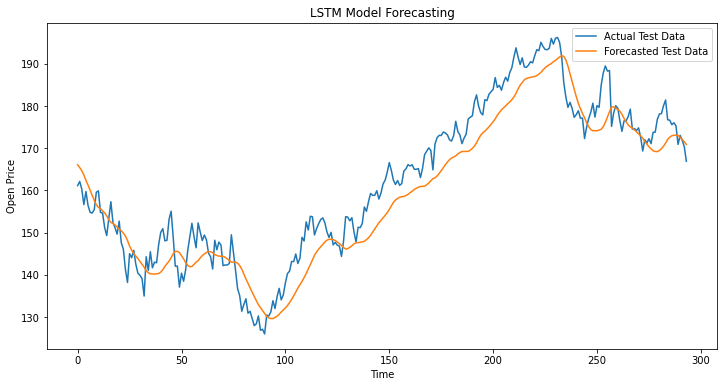

In [139]:
# Plotting the forecasted values against the actual test values
plt.figure(figsize=(12, 6))
plt.plot(testY, label='Actual Test Data')
plt.plot(y_pred_test, label='Forecasted Test Data')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.title('LSTM Model Forecasting')
plt.legend()
plt.show()
